# 2018 CDC Natality Data Set

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.optimize import minimize

warnings.filterwarnings('ignore')
my_cmap = cm.get_cmap('tab10')

## Data Cleaning

In [2]:
# df = pd.read_csv('../data/NBER/natl2018us.csv')

# # Keep only single births and first pregnancy
# df = df[df['dplural'] == 1]
# df = df[df['ilp_r'] == 888]

# # Subset of indicators to consider
# df = df[['mager9', 'mbstate_rec', 'mracehisp', 'meduc', 'precare5', 'wic', 'pay_rec']]

# # Get rid of unknowns
# df = df[df['mbstate_rec'] != 3] # Unknown nativity
# df = df[df['mracehisp'] != 8]   # Unknown race
# df = df[df['meduc'] != 9]       # Unknown education
# df = df[df['precare5'] != 5]    # Unknown prenatal care
# df = df[df['wic'] != 'U']       # Unknown WIC
# df = df[df['pay_rec'] != 9]     # Unknown payment method

# # Change encoding for nativity
# df['mbstate_rec'] = df.apply(lambda row: int(row['mbstate_rec'] == 1), axis=1)

# # Change encoding for WIC
# df['wic'] = df.apply(lambda row: int(row['wic'] == 'Y'), axis=1)

# # Add column for prenatal care
# df['prenatal'] = df.apply(lambda row: int(row['precare5'] != 4), axis=1)

# # Save subset
# df.to_csv('../data/NBER/natl2018us_subset.csv', index=False)
df = pd.read_csv('../data/NBER/natl2018us_subset.csv')

## Indicators

In [3]:
# Month prenatal care began (`precare5`)
month_dict = {
    1: '1st-3rd month',
    2: '4th-6th month',
    3: '7th-final month',
    4: 'No prenatal care'
}

# Mother's age (`mager9`)
age_dict = {
    1: 'Under 15 years',
    2: '15-19 years',
    3: '20-24 years',
    4: '25-29 years',
    5: '30-34 years',
    6: '35-39 years',
    7: '40-44 years',
    8: '45-49 years',
    9: '50-54 years'
}

# Mother's nativity (`mbstate_rec`)
nat_dict = {
    0: 'Born outside the US',
    1: 'Born in the US'
}

# Mother's race/Hispanic origin (`mracehisp`)
race_dict = {
    1: 'White',
    2: 'Black',
    3: 'AIAN',
    4: 'Asian',
    5: 'NHOPI',
    6: 'More than one race',
    7: 'Hispanic'
}

# Mother's education (`meduc`)
educ_dict = {
    1: '8th grade or less',
    2: '9th through 12th with no diploma',
    3: 'High school graduate or GED completed',
    4: 'Some college credit, but not a degree',
    5: 'Associate degree',
    6: "Bachelor's degree",
    7: "Master's degree",
    8: 'Doctorate'
}

# WIC (`wic`)
wic_dict = {
    0: 'No',
    1: 'Yes'
}

# Payment source for delivery (`pay_rec`)  
pay_dict = {
    1: 'Medicaid',
    2: 'Private Insurance',
    3: 'Self Pay',
    4: 'Other'
}

## Who gets prenatal care?

In [4]:
def plot_care(col, col_name, col_dict):
    fig, ax = plt.subplots()
    col_list = []
    per_list = []
    for ii in np.sort(df[col].unique()):
        df_sub = df[df[col] == ii]
        col_list.append(col_dict[ii])
        per_list.append(100*len(df_sub[df_sub['prenatal'] == 1])/len(df_sub))
    temp = pd.DataFrame({
        col_name: col_list,
        'Care': per_list
    })
    sns.barplot(x=col_name, y='Care', data=temp, ax=ax)
    ax.set_xticklabels(col_list, rotation=90)
    ax.set_ylabel(f"Percent Had Prenatal Care")

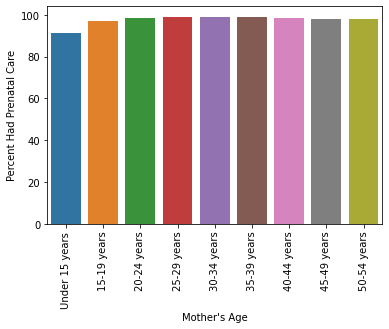

In [5]:
plot_care('mager9', "Mother's Age", age_dict)

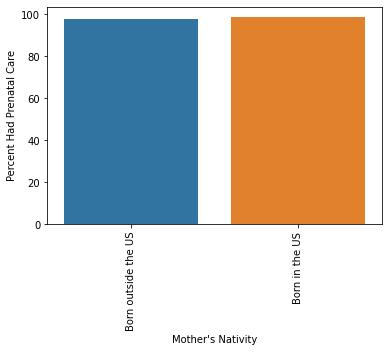

In [6]:
plot_care('mbstate_rec', "Mother's Nativity", nat_dict)

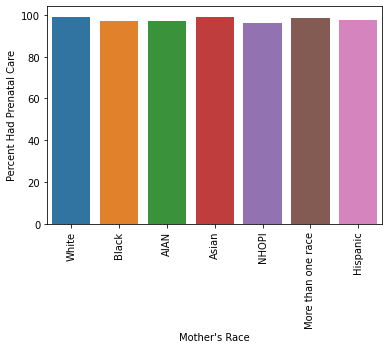

In [7]:
plot_care('mracehisp', "Mother's Race", race_dict)

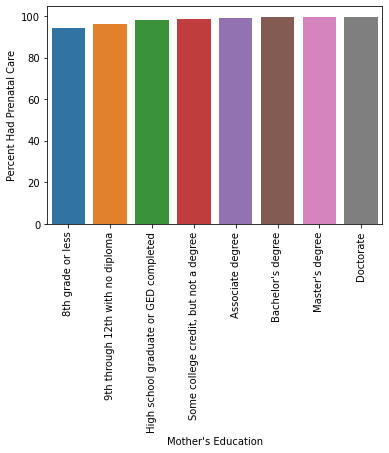

In [8]:
plot_care('meduc', "Mother's Education", educ_dict)

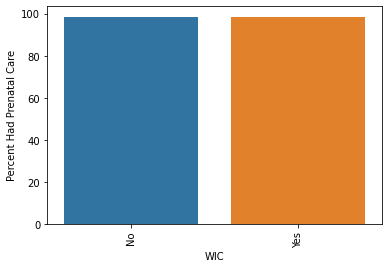

In [9]:
plot_care('wic', 'WIC', wic_dict)

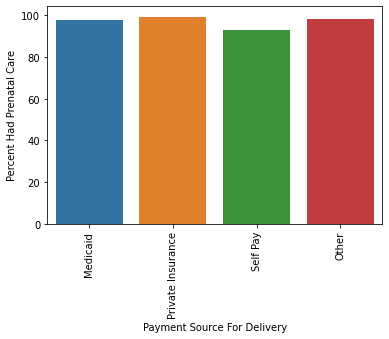

In [10]:
plot_care('pay_rec', 'Payment Source For Delivery', pay_dict)

In [ ]:
# What about the same plots for my subsets?

## Can we predict who gets prenatal care?

Prediction accuracy: 69.27%, Converge: True


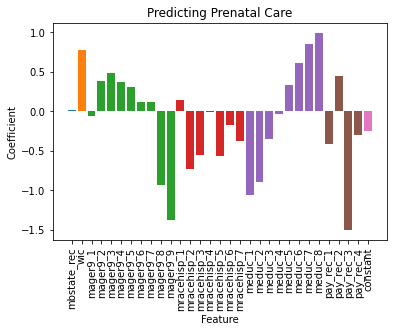

In [11]:
np.random.seed(0)

# Create dummy variables
data = pd.get_dummies(df, columns=['mager9', 'mracehisp', 'meduc', 'pay_rec'])
data.drop(columns='precare5', inplace=True)
group_dict = {
    0: [0],               # mbstate_rec
    1: [1],               # wic
    2: np.arange(2, 11),  # mager9
    3: np.arange(11, 18), # mracehisp
    4: np.arange(18, 26), # meduc
    5: np.arange(26, 30), # pay_rec
    6: [30]               # constant
}
group_name = {
    0: 'mbstate_rec',
    1: 'wic',
    2: 'mager9',
    3: 'mracehisp',
    4: 'meduc',
    5: 'pay_rec',
    6: 'constant'
}

# Select equal group sizes
idx_0 = data[data['prenatal'] == 0].index.tolist()
idx_1 = data[data['prenatal'] == 1].index.tolist()
n = np.min([len(idx_0), len(idx_1)])
idx = np.random.choice(idx_0, n, replace=False).tolist() + \
      np.random.choice(idx_1, n, replace=False).tolist()

# Create feature matrix and outcome vector
data_sub = data.loc[idx]
y = data_sub['prenatal'].values
features = [col != 'prenatal' for col in data_sub.columns]
X = data_sub.loc[:, features].values
X = np.hstack((X, np.ones((2*n, 1))))

# Define loss function
def loss(b, lam, group=False):
    Xb = X.dot(b)
    nll = (np.sum(np.log(1 + np.exp(Xb))) - y.dot(Xb))/n
    if group:
        return nll + lam*reg(b)
    return nll + lam*np.linalg.norm(b, 1)

# Define regularization function for group sparsity
def reg(b):
    reg_sum = 0
    for group in group_dict:
        reg_sum += np.linalg.norm(b[group_dict[group]], 2)
    return reg_sum

# Solution with no regularization
res0 = minimize(lambda b: loss(b, 0), np.random.randn(31))

# Plot coefficients
c = [my_cmap(ii) for ii in group_dict for jj in group_dict[ii]]
plt.bar(np.arange(len(res0.x)), res0.x, color=c)
plt.xticks(np.arange(len(res0.x)), list(data_sub.columns[features]) + ['constant'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Predicting Prenatal Care')

# Prediction accuracy
y_pred = X.dot(res0.x)
y_pred = 1*(y_pred >= 0)
print(f"Prediction accuracy: {100*sum(y_pred == y)/len(y):.2f}%, Converge: {res0.success}") 

### L1 Regularization

Lambda: 1.0000e-04, Prediction accuracy: 69.27%, Converge: False
Lambda: 1.4678e-04, Prediction accuracy: 69.28%, Converge: False
Lambda: 2.1544e-04, Prediction accuracy: 69.28%, Converge: False
Lambda: 3.1623e-04, Prediction accuracy: 69.30%, Converge: False
Lambda: 4.6416e-04, Prediction accuracy: 69.26%, Converge: False
Lambda: 6.8129e-04, Prediction accuracy: 69.25%, Converge: False
Lambda: 1.0000e-03, Prediction accuracy: 69.26%, Converge: False
Lambda: 1.4678e-03, Prediction accuracy: 69.29%, Converge: False
Lambda: 2.1544e-03, Prediction accuracy: 69.28%, Converge: False
Lambda: 3.1623e-03, Prediction accuracy: 69.31%, Converge: False
Lambda: 4.6416e-03, Prediction accuracy: 69.31%, Converge: False
Lambda: 6.8129e-03, Prediction accuracy: 68.90%, Converge: False
Lambda: 1.0000e-02, Prediction accuracy: 68.77%, Converge: False
Lambda: 1.4678e-02, Prediction accuracy: 68.21%, Converge: False
Lambda: 2.1544e-02, Prediction accuracy: 67.79%, Converge: False
Lambda: 3.1623e-02, Predi

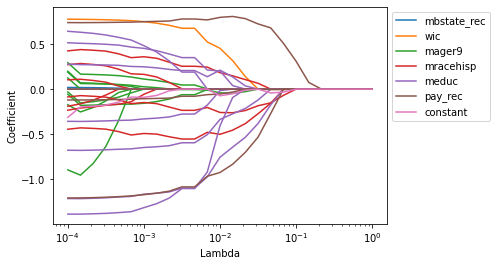

In [12]:
x00_list = [res0.x]
lam_list = np.logspace(-4, 0, 25)
for ii, lam in enumerate(lam_list):
    res = minimize(lambda b: loss(b, lam), x00_list[ii])
    y_pred = X.dot(res.x)
    y_pred = 1*(y_pred >= 0)
    print(f"Lambda: {lam:.4e}, Prediction accuracy: {100*sum(y_pred == y)/len(y):.2f}%, Converge: {res.success}") 
    x00_list.append(res.x)

def get_group(ii):
    for group in group_dict:
        if ii in group_dict[group]:
            return group

def add_label(ii):
    for group in group_dict:
        if ii == group_dict[group][0]:
            return True
    return False

coefs = np.array(x00_list)
for ii in range(31):
    group = get_group(ii)
    if add_label(ii):
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group), label=group_name[group])
    else:
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group))        
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Lambda')
plt.ylabel('Coefficient');

### Group Sparsity

Lambda: 1.0000e-04, Prediction accuracy: 69.26%, Converge: True
Lambda: 1.4678e-04, Prediction accuracy: 69.26%, Converge: True
Lambda: 2.1544e-04, Prediction accuracy: 69.27%, Converge: False
Lambda: 3.1623e-04, Prediction accuracy: 69.26%, Converge: True
Lambda: 4.6416e-04, Prediction accuracy: 69.27%, Converge: True
Lambda: 6.8129e-04, Prediction accuracy: 69.26%, Converge: True
Lambda: 1.0000e-03, Prediction accuracy: 69.28%, Converge: False
Lambda: 1.4678e-03, Prediction accuracy: 69.28%, Converge: False
Lambda: 2.1544e-03, Prediction accuracy: 69.28%, Converge: False
Lambda: 3.1623e-03, Prediction accuracy: 69.27%, Converge: False
Lambda: 4.6416e-03, Prediction accuracy: 69.25%, Converge: False
Lambda: 6.8129e-03, Prediction accuracy: 69.14%, Converge: True
Lambda: 1.0000e-02, Prediction accuracy: 69.05%, Converge: False
Lambda: 1.4678e-02, Prediction accuracy: 68.91%, Converge: False
Lambda: 2.1544e-02, Prediction accuracy: 68.91%, Converge: False
Lambda: 3.1623e-02, Prediction 

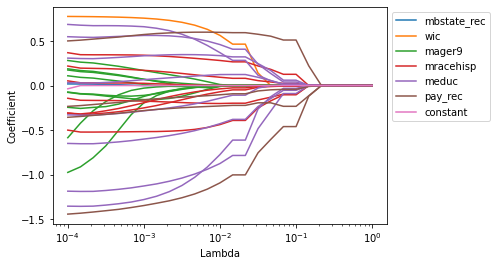

In [13]:
x01_list = [res0.x]
for ii, lam in enumerate(lam_list):
    res = minimize(lambda b: loss(b, lam, True), x01_list[ii])
    y_pred = X.dot(res.x)
    y_pred = 1*(y_pred >= 0)
    print(f"Lambda: {lam:.4e}, Prediction accuracy: {100*sum(y_pred == y)/len(y):.2f}%, Converge: {res.success}") 
    x01_list.append(res.x)

coefs = np.array(x01_list)
for ii in range(31):
    group = get_group(ii)
    if add_label(ii):
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group), label=group_name[group])
    else:
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group))
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Lambda')
plt.ylabel('Coefficient');

## When do people start prenatal care?

In [14]:
def plot_month(col, col_name, col_dict):
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    for ii in np.sort(df['precare5'].unique()):
        col_list = []
        per_list = [] 
        for jj in np.sort(df[col].unique()):
            df_sub = df[df[col] == jj]
            col_list.append(col_dict[jj])
            per_list.append(100*len(df_sub[df_sub['precare5'] == ii])/len(df_sub))
        temp = pd.DataFrame({
            col_name: col_list,
            'Care': per_list
        })
        sns.barplot(x=col_name, y='Care', data=temp, ax=ax[ii-1])
        ax[ii-1].set_xticklabels(col_list, rotation=90)
        if ii == 4:
            ax[ii-1].set_ylabel(f"Percent {month_dict[ii]}")
        else:
            ax[ii-1].set_ylabel(f"Percent Started Care in {month_dict[ii]}")

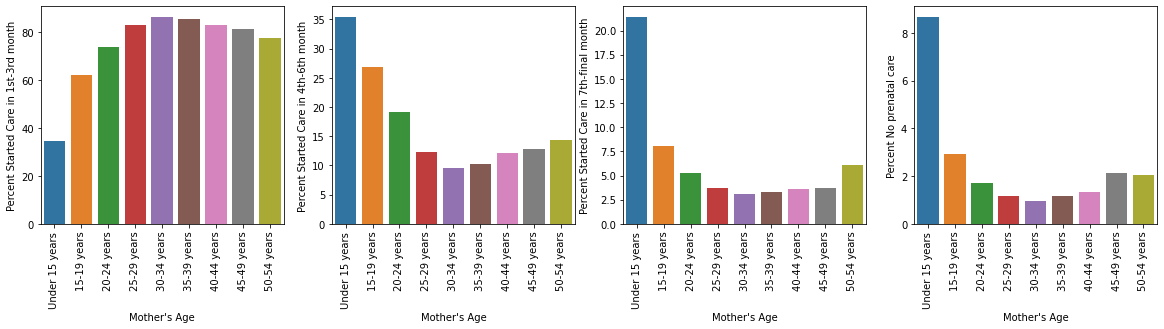

In [15]:
plot_month('mager9', "Mother's Age", age_dict)

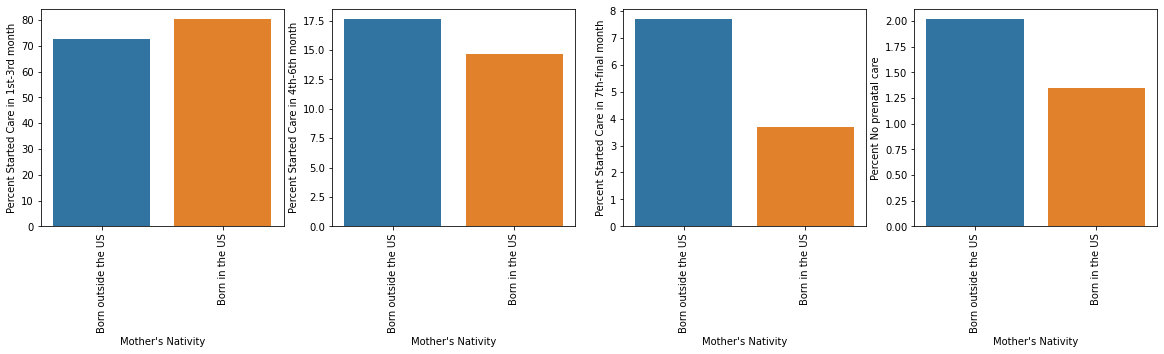

In [16]:
plot_month('mbstate_rec', "Mother's Nativity", nat_dict)

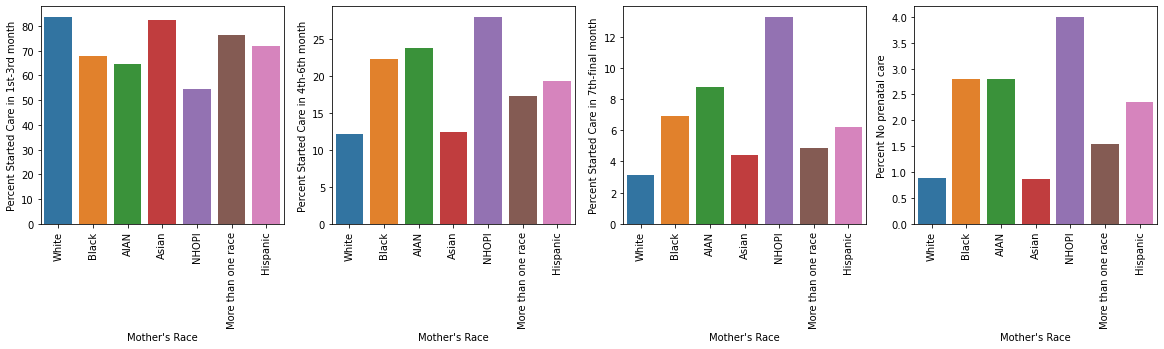

In [17]:
plot_month('mracehisp', "Mother's Race", race_dict)

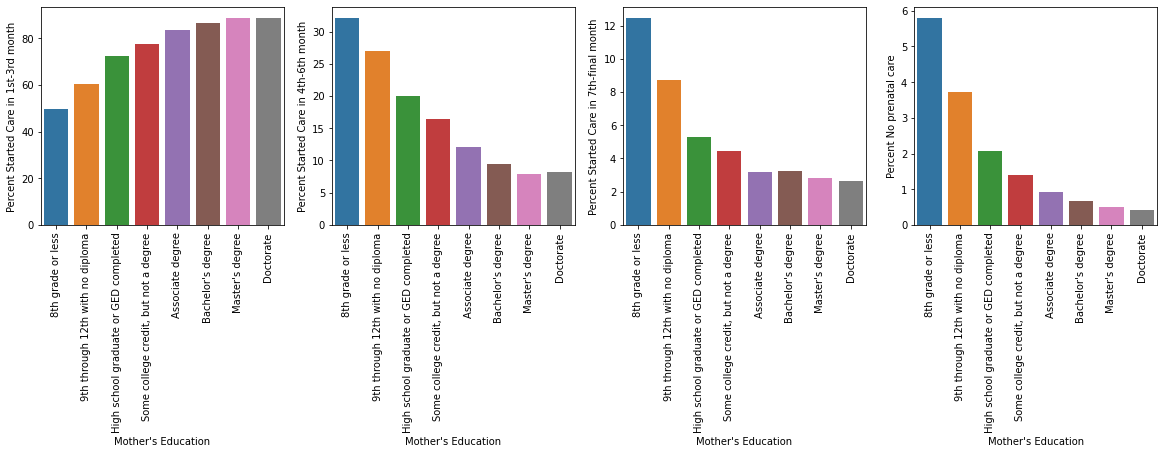

In [18]:
plot_month('meduc', "Mother's Education", educ_dict)

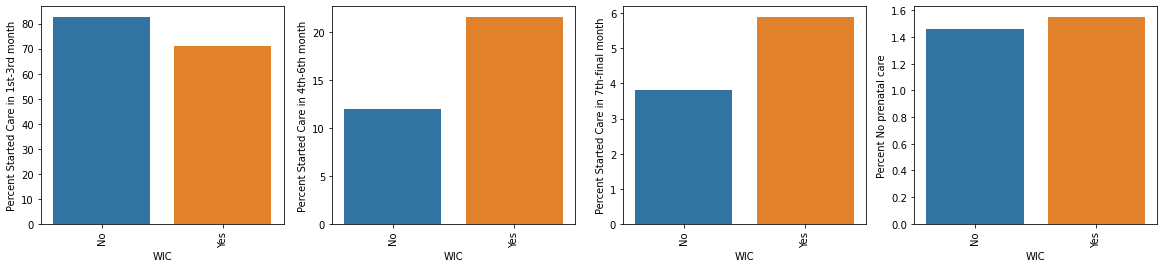

In [19]:
plot_month('wic', 'WIC', wic_dict)

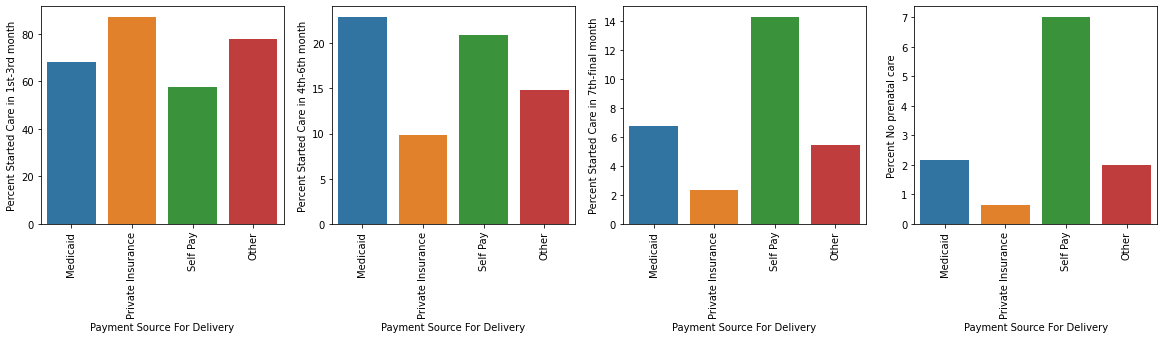

In [20]:
plot_month('pay_rec', 'Payment Source For Delivery', pay_dict)

## Can we predict when someone will get prenatal care? (first trimester)

Prediction accuracy: 64.85%, Converge: True


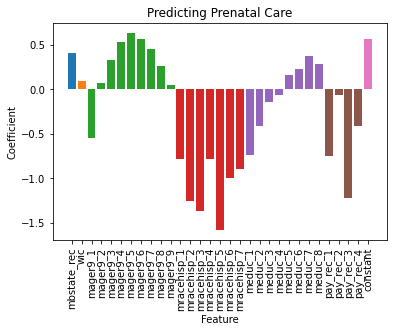

In [21]:
np.random.seed(0)

# Create dummy variables
data = pd.get_dummies(df, columns=['mager9', 'mracehisp', 'meduc', 'pay_rec'])
data['prenatal'] = data.apply(lambda row: int(row['precare5'] == 1), axis=1)
data.drop(columns='precare5', inplace=True)
group_dict = {
    0: [0],               # mbstate_rec
    1: [1],               # wic
    2: np.arange(2, 11),  # mager9
    3: np.arange(11, 18), # mracehisp
    4: np.arange(18, 26), # meduc
    5: np.arange(26, 30), # pay_rec
    6: [30]               # constant
}
group_name = {
    0: 'mbstate_rec',
    1: 'wic',
    2: 'mager9',
    3: 'mracehisp',
    4: 'meduc',
    5: 'pay_rec',
    6: 'constant'
}

# Select equal group sizes
idx_0 = data[data['prenatal'] == 0].index.tolist()
idx_1 = data[data['prenatal'] == 1].index.tolist()
n = np.min([len(idx_0), len(idx_1)])
idx = np.random.choice(idx_0, n, replace=False).tolist() + \
      np.random.choice(idx_1, n, replace=False).tolist()

# Create feature matrix and outcome vector
data_sub = data.loc[idx]
y = data_sub['prenatal'].values
features = [col != 'prenatal' for col in data_sub.columns]
X = data_sub.loc[:, features].values
X = np.hstack((X, np.ones((2*n, 1))))

# Define loss function
def loss(b, lam, group=False):
    Xb = X.dot(b)
    nll = (np.sum(np.log(1 + np.exp(Xb))) - y.dot(Xb))/n
    if group:
        return nll + lam*reg(b)
    return nll + lam*np.linalg.norm(b, 1)

# Define regularization function for group sparsity
def reg(b):
    reg_sum = 0
    for group in group_dict:
        reg_sum += np.linalg.norm(b[group_dict[group]], 2)
    return reg_sum

# Solution with no regularization
res1 = minimize(lambda b: loss(b, 0), np.random.randn(31))

# Plot coefficients
c = [my_cmap(ii) for ii in group_dict for jj in group_dict[ii]]
plt.bar(np.arange(len(res1.x)), res1.x, color=c)
plt.xticks(np.arange(len(res1.x)), list(data_sub.columns[features]) + ['constant'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Predicting Prenatal Care')

# Prediction accuracy
y_pred = X.dot(res1.x)
y_pred = 1*(y_pred >= 0)
print(f"Prediction accuracy: {100*sum(y_pred == y)/len(y):.2f}%, Converge: {res1.success}")

### L1 Regularization

Lambda: 1.0000e-04, Prediction accuracy: 64.92%, Converge: False
Lambda: 1.4678e-04, Prediction accuracy: 64.92%, Converge: False
Lambda: 2.1544e-04, Prediction accuracy: 64.92%, Converge: False
Lambda: 3.1623e-04, Prediction accuracy: 64.92%, Converge: True
Lambda: 4.6416e-04, Prediction accuracy: 64.93%, Converge: False
Lambda: 6.8129e-04, Prediction accuracy: 64.94%, Converge: False
Lambda: 1.0000e-03, Prediction accuracy: 64.93%, Converge: False
Lambda: 1.4678e-03, Prediction accuracy: 64.96%, Converge: False
Lambda: 2.1544e-03, Prediction accuracy: 64.96%, Converge: False
Lambda: 3.1623e-03, Prediction accuracy: 64.88%, Converge: False
Lambda: 4.6416e-03, Prediction accuracy: 64.85%, Converge: False
Lambda: 6.8129e-03, Prediction accuracy: 64.76%, Converge: False
Lambda: 1.0000e-02, Prediction accuracy: 64.76%, Converge: False
Lambda: 1.4678e-02, Prediction accuracy: 64.55%, Converge: False
Lambda: 2.1544e-02, Prediction accuracy: 64.55%, Converge: False
Lambda: 3.1623e-02, Predic

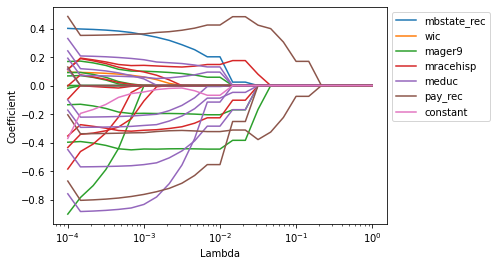

In [22]:
x10_list = [res1.x]
for ii, lam in enumerate(lam_list):
    res = minimize(lambda b: loss(b, lam), x10_list[ii])
    y_pred = X.dot(res.x)
    y_pred = 1*(y_pred >= 0)
    print(f"Lambda: {lam:.4e}, Prediction accuracy: {100*sum(y_pred == y)/len(y):.2f}%, Converge: {res.success}") 
    x10_list.append(res.x)

coefs = np.array(x10_list)
for ii in range(31):
    group = get_group(ii)
    if add_label(ii):
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group), label=group_name[group])
    else:
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group))        
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Lambda')
plt.ylabel('Coefficient');

### Group Sparsity

Lambda: 1.0000e-04, Prediction accuracy: 64.91%, Converge: True
Lambda: 1.4678e-04, Prediction accuracy: 64.92%, Converge: True
Lambda: 2.1544e-04, Prediction accuracy: 64.92%, Converge: True
Lambda: 3.1623e-04, Prediction accuracy: 64.91%, Converge: True
Lambda: 4.6416e-04, Prediction accuracy: 64.92%, Converge: True
Lambda: 6.8129e-04, Prediction accuracy: 64.92%, Converge: True
Lambda: 1.0000e-03, Prediction accuracy: 64.93%, Converge: True
Lambda: 1.4678e-03, Prediction accuracy: 64.96%, Converge: True
Lambda: 2.1544e-03, Prediction accuracy: 64.95%, Converge: True
Lambda: 3.1623e-03, Prediction accuracy: 64.97%, Converge: True
Lambda: 4.6416e-03, Prediction accuracy: 64.93%, Converge: False
Lambda: 6.8129e-03, Prediction accuracy: 64.95%, Converge: False
Lambda: 1.0000e-02, Prediction accuracy: 64.85%, Converge: False
Lambda: 1.4678e-02, Prediction accuracy: 64.63%, Converge: False
Lambda: 2.1544e-02, Prediction accuracy: 64.52%, Converge: False
Lambda: 3.1623e-02, Prediction accu

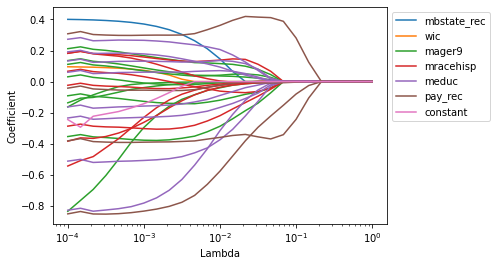

In [23]:
x11_list = [res0.x]
for ii, lam in enumerate(lam_list):
    res = minimize(lambda b: loss(b, lam, True), x10_list[ii])
    y_pred = X.dot(res.x)
    y_pred = 1*(y_pred >= 0)
    print(f"Lambda: {lam:.4e}, Prediction accuracy: {100*sum(y_pred == y)/len(y):.2f}%, Converge: {res.success}") 
    x11_list.append(res.x)

coefs = np.array(x11_list)
for ii in range(31):
    group = get_group(ii)
    if add_label(ii):
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group), label=group_name[group])
    else:
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group))
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Lambda')
plt.ylabel('Coefficient');

In [ ]:
#coefficient * standard deviation of corresponding variable?
# https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model

In [26]:
np.save('x00_list.npy', x00_list)

In [27]:
np.save('x01_list.npy', x00_list)

In [28]:
np.save('x10_list.npy', x00_list)

In [29]:
np.save('x11_list.npy', x00_list)